In [1]:
pip install pytorch-msssim

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
  Using cached nvidia_nvjitlink_cu12-12.4.127-py3-none-m

In [2]:
#Importing the libraries
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset,DataLoader
from torchvision import models,datasets,transforms

from tqdm import tqdm
import os
from PIL import Image
import matplotlib.pyplot as plt
import math
import random
from pytorch_msssim import ssim
import pickle

In [3]:
#Checking if a GPU with CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [4]:
#Creating a custom dataset class that generates the noisy counterpart of the clean image and returns both of them
class CustomDataset(Dataset):
  def __init__(self,dir_name,train_flag,sigma):
    """
    train_flag is True for the Train dataset and False for the evaluation dataset
    sigma is the noise level
    """
    super().__init__()
    #Defining the transforms for the train and test datasets
    self.test_transform = transforms.Compose([transforms.ToTensor()])

    self.train_flag = train_flag

    #Downloading the train and test datasets
    if train_flag:
      pfile = open(dir_name, 'rb')     #opening the pickle file
      self.dataset = pickle.load(pfile) #Reading the tensors from the pickle file
      pfile.close() #Closing the pickle file

    else:
      self.dataset = []
      for cl in os.listdir(dir_name):
        for img_name in os.listdir(os.path.join(dir_name,cl)):
          self.dataset.append(os.path.join(dir_name,cl,img_name))

    self.sigma = sigma

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, index):
    if self.train_flag:
      clean_img = self.dataset[index].unsqueeze(0) #of shape (1,40,40)

    else:
      im = Image.open(self.dataset[index]).convert("L") #PIL object in grayscale
      clean_img = self.test_transform(im) #of shape (1,h,w)

    #Generating the noisy image
    noisy_img = (torch.randn(clean_img.shape)*(self.sigma/255.))+clean_img
    return clean_img, noisy_img



In [5]:
#Defining a Block of the DnCNN
class Block(nn.Module):
  def __init__(self,k=3,p=1,c=64):
    super().__init__()
    self.conv = nn.Conv2d(in_channels=c,out_channels=c,kernel_size=k,padding=p,bias=False) #same padding convolution
    self.norm = nn.BatchNorm2d(c) #batch normalization
    self.relu = nn.ReLU(inplace=True) #activation function

  def forward(self,x):
    x = self.conv(x)
    x = self.norm(x)
    x = self.relu(x)
    return x


In [6]:
#Defining the DnCNN model
class DCNN(nn.Module):
  def __init__(self,k=3,p=1,c=64,l=17,in_c=1):
    super().__init__()
    layers = [nn.Conv2d(in_channels=in_c,out_channels=c,kernel_size=k,padding=p,bias=False), #First same padding convolution layer
              nn.ReLU(inplace=True)]
    layers.extend([Block(k,p,c) for _ in range(l-2)]) #Adding all the "Blocks" to the model
    layers.append(nn.Conv2d(in_channels=c,out_channels=in_c,kernel_size=k,padding=p,bias=False)) #Last same padding convolution layer

    self.all = nn.Sequential(*layers)

  def forward(self,x):
    out = self.all(x)
    return x-out


In [7]:
def test_baseline(criterion,device,test_loader):
  """
  criterion is the function used to compute PSNR
  device is either CPU or GPU(cuda)
  test_loader is the DataLoader containing the test dataset
  """

  loop = tqdm(test_loader)
  total_mse = []
  total_ssim = []

  with torch.no_grad():
    for i,(clean,noisy) in enumerate(loop):
      clean,noisy = clean.to(device).float(), noisy.to(device).float()

      clean_pred = torch.clamp(noisy,min=0.0,max=1.0)
      loss = (criterion(clean_pred,clean).mean(axis=(1,2,3))).tolist()
      total_mse.extend(loss)

      ssim_val = ssim(clean,clean_pred, data_range=1, size_average=False).tolist() #of shape of batch size
      total_ssim.extend(ssim_val)

  total_mse_tensor = torch.tensor(total_mse)
  psnr = (-10*torch.log10(total_mse_tensor)).mean()

  ssim_val = (torch.tensor(total_ssim)).mean()

  print(f"\n The PSNR is {psnr} and the SSIM is {ssim_val}")

In [8]:
def test_supervised(criterion,model,device,test_loader):
  """
  criterion is the function used to compute PSNR
  model is the trained supervised DnCNN model
  device is either CPU or GPU(cuda)
  test_loader is the DataLoader containing the test dataset
  """
  model.eval()
  loop = tqdm(test_loader) #Used to visualize the progress in testing
  total_mse = []
  total_ssim = []

  with torch.no_grad():
    for i,(clean,noisy) in enumerate(loop):
      clean,noisy = clean.to(device).float(), noisy.to(device).float()
      out = model(noisy)

      clean_pred = torch.clamp(out,min=0.0,max=1.0)

      #Computing PSNR
      loss = (criterion(clean_pred,clean).mean(axis=(1,2,3))).tolist()
      total_mse.extend(loss)

      #Computing SSIM
      ssim_val = ssim(clean,clean_pred, data_range=1, size_average=False).tolist() #of shape of batch size
      total_ssim.extend(ssim_val)

  total_mse_tensor = torch.tensor(total_mse)
  psnr = (-10*torch.log10(total_mse_tensor)).mean()

  ssim_val = (torch.tensor(total_ssim)).mean()

  print(f"\n The PSNR is {psnr} and the SSIM is {ssim_val}")


In [9]:
def test_unsupervised(criterion,model,device,test_loader,alpha,sigma,T):
  """
  criterion is the function used to compute PSNR
  model is the trained unsupervised denoiser model
  device is either CPU or GPU(cuda)
  test_loader is the DataLoader containing the test dataset
  sigma is the noise level
  alpha is the constant of 0.5
  T is the number of forward processes averaged to reduce the effect of recorruption
  """

  model.eval()
  loop = tqdm(test_loader)  #Used to visualize the progress in testing
  total_mse = []
  total_ssim = []

  with torch.no_grad():
    for i,(clean,noisy) in enumerate(loop):
      clean,noisy = clean.to(device).float(), noisy.to(device).float()

      out = torch.zeros(clean.shape).to(device)
      for _ in range(T):
        noise = (torch.randn(noisy.shape)*(sigma/255.)).to(device)
        noisy_main = noisy+alpha*noise
        out += model(noisy_main)

      clean_pred = torch.clamp(out/T,min=0.0,max=1.0)

      #Computing PSNR
      loss = (criterion(clean_pred,clean).mean(axis=(1,2,3))).tolist()
      total_mse.extend(loss)
      #Computing SSIM
      ssim_val = ssim(clean,clean_pred, data_range=1, size_average=False).tolist() #of shape of batch size
      total_ssim.extend(ssim_val)

  total_mse_tensor = torch.tensor(total_mse)
  psnr = (-10*torch.log10(total_mse_tensor)).mean()

  ssim_val = (torch.tensor(total_ssim)).mean()

  print(f"\n The PSNR is {psnr} and the SSIM is {ssim_val}")

In [21]:
def display(test_set,index,model_sup,model_unsup,alpha,sigma,T):
  """
  test_set is the contains all the images of the test set
  index is a number to select an image from the test set
  model_sup is the trained supervised denoiser
  model_unsup is the trained unsupervised (R2R) denoiser
  alpha is a number
  sigma is the noise level
  T is the number of times the noisy image is passed through the unsupervised denoiser to generate clean image

  """
  clean, noisy = test_set[index]
  clean, noisy = clean.to(device), noisy.to(device)

  #For supervised Denoising
  model_sup.eval()
  out_sup = model_sup(noisy.unsqueeze(0).to(device))

  clean_pred_sup = torch.clamp(out_sup,min=0.0,max=1.0)

  #For unsupervised Denoising
  model_unsup.eval()
  out_unsup = torch.zeros(noisy.shape).unsqueeze(0).to(device)

  with torch.no_grad():
    for _ in range(T):
      noise = (torch.randn(noisy.shape)*(sigma/255.)).to(device)
      noisy_main = noisy+alpha*noise
      out_unsup += model_unsup(noisy_main.unsqueeze(0))

  clean_pred_unsup = torch.clamp(out_unsup/T,min=0.0,max=1.0)

  fig,axes = plt.subplots(nrows=2, ncols=2,figsize=(25,25))

  axes[0][0].imshow(clean.cpu().squeeze(),cmap="gray")
  axes[0][0].axis("off")
  axes[0][0].set_title("Ground Truth Clean Image",fontsize=40)

  axes[0][1].imshow(noisy.cpu().squeeze(),cmap="gray")
  axes[0][1].axis("off")
  axes[0][1].set_title("Noisy Image",fontsize=40)

  axes[1][0].imshow(clean_pred_sup.cpu().squeeze().detach(),cmap="gray")
  axes[1][0].axis("off")
  axes[1][0].set_title("Supervised Denoised Image",fontsize=40)

  axes[1][1].imshow(clean_pred_unsup.cpu().squeeze().detach(),cmap="gray")
  axes[1][1].axis("off")
  axes[1][1].set_title("Unsupervised Denoised Image",fontsize=40)

  plt.show()

In [11]:
criterion_test = nn.MSELoss(reduce=False)

/usr/local/lib/python3.10/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


In [12]:
#Loading all the supervised models
model_sup_10 = DCNN().to(device)
model_sup_10.load_state_dict(torch.load("/content/Supervised7_39.56_10.pt"))

model_sup_25 = DCNN().to(device)
model_sup_25.load_state_dict(torch.load("/content/Supervised5_35.8_25.pt"))

model_sup_50 = DCNN().to(device)
model_sup_50.load_state_dict(torch.load("/content/Supervised8_33.19_50.pt"))

<All keys matched successfully>

In [13]:
#Loading all the unsupervised models
model_unsup_10 = DCNN().to(device)
model_unsup_10.load_state_dict(torch.load("/content/Unsupervised7_39.48_10.pt"))

model_unsup_25 = DCNN().to(device)
model_unsup_25.load_state_dict(torch.load("/content/Unsupervised9_35.78_25.pt"))

model_unsup_50 = DCNN().to(device)
model_unsup_50.load_state_dict(torch.load("/content/Unsupervised9_32.67_50.pt"))

<All keys matched successfully>

In [17]:
#Defines the loaders for the train and test set
test_set_10 = CustomDataset("/content/drive/MyDrive/R2R_ML/Covid_dataset/split4",False,10)
test_loader_10 = DataLoader(test_set_10,batch_size=1,shuffle=False,num_workers=1)

test_set_25 = CustomDataset("/content/drive/MyDrive/R2R_ML/Covid_dataset/split4",False,25)
test_loader_25 = DataLoader(test_set_25,batch_size=1,shuffle=False,num_workers=1)

test_set_50 = CustomDataset("/content/drive/MyDrive/R2R_ML/Covid_dataset/split4",False,50)
test_loader_50 = DataLoader(test_set_50,batch_size=1,shuffle=False,num_workers=1)

In [ ]:
test_baseline(criterion_test,device,test_loader_10)

  0%|          | 0/517 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 517/517 [03:11<00:00,  2.70it/s]


 The PSNR is 28.874242782592773 and the SSIM is 0.46215611696243286


In [ ]:
test_baseline(criterion_test,device,test_loader_25)

100%|██████████| 517/517 [00:04<00:00, 107.95it/s]


 The PSNR is 21.40813446044922 and the SSIM is 0.15272705256938934


In [ ]:
test_baseline(criterion_test,device,test_loader_50)

100%|██████████| 517/517 [00:05<00:00, 99.12it/s] 


 The PSNR is 15.928548812866211 and the SSIM is 0.05193804204463959


In [ ]:
test_supervised(criterion_test,model_sup_10,device,test_loader_10)

100%|██████████| 517/517 [00:13<00:00, 39.02it/s]


 The PSNR is 39.56221389770508 and the SSIM is 0.944229781627655


In [ ]:
test_supervised(criterion_test,model_sup_25,device,test_loader_25)

100%|██████████| 517/517 [00:13<00:00, 39.27it/s]


 The PSNR is 35.80850601196289 and the SSIM is 0.8936240077018738


In [ ]:
test_supervised(criterion_test,model_sup_50,device,test_loader_50)

100%|██████████| 517/517 [00:13<00:00, 39.32it/s]


 The PSNR is 33.19500732421875 and the SSIM is 0.8271433115005493


In [ ]:
test_unsupervised(criterion_test,model_unsup_10,device,test_loader_10,alpha=0.5,sigma=10,T=50)

100%|██████████| 517/517 [09:04<00:00,  1.05s/it]


 The PSNR is 39.480838775634766 and the SSIM is 0.9445462226867676


In [ ]:
test_unsupervised(criterion_test,model_unsup_25,device,test_loader_25,alpha=0.5,sigma=25,T=50)

100%|██████████| 517/517 [09:04<00:00,  1.05s/it]


 The PSNR is 35.77969741821289 and the SSIM is 0.8856053352355957


In [ ]:
test_unsupervised(criterion_test,model_unsup_50,device,test_loader_50,alpha=0.5,sigma=50,T=50)

100%|██████████| 517/517 [09:04<00:00,  1.05s/it]


 The PSNR is 32.668453216552734 and the SSIM is 0.75261390209198


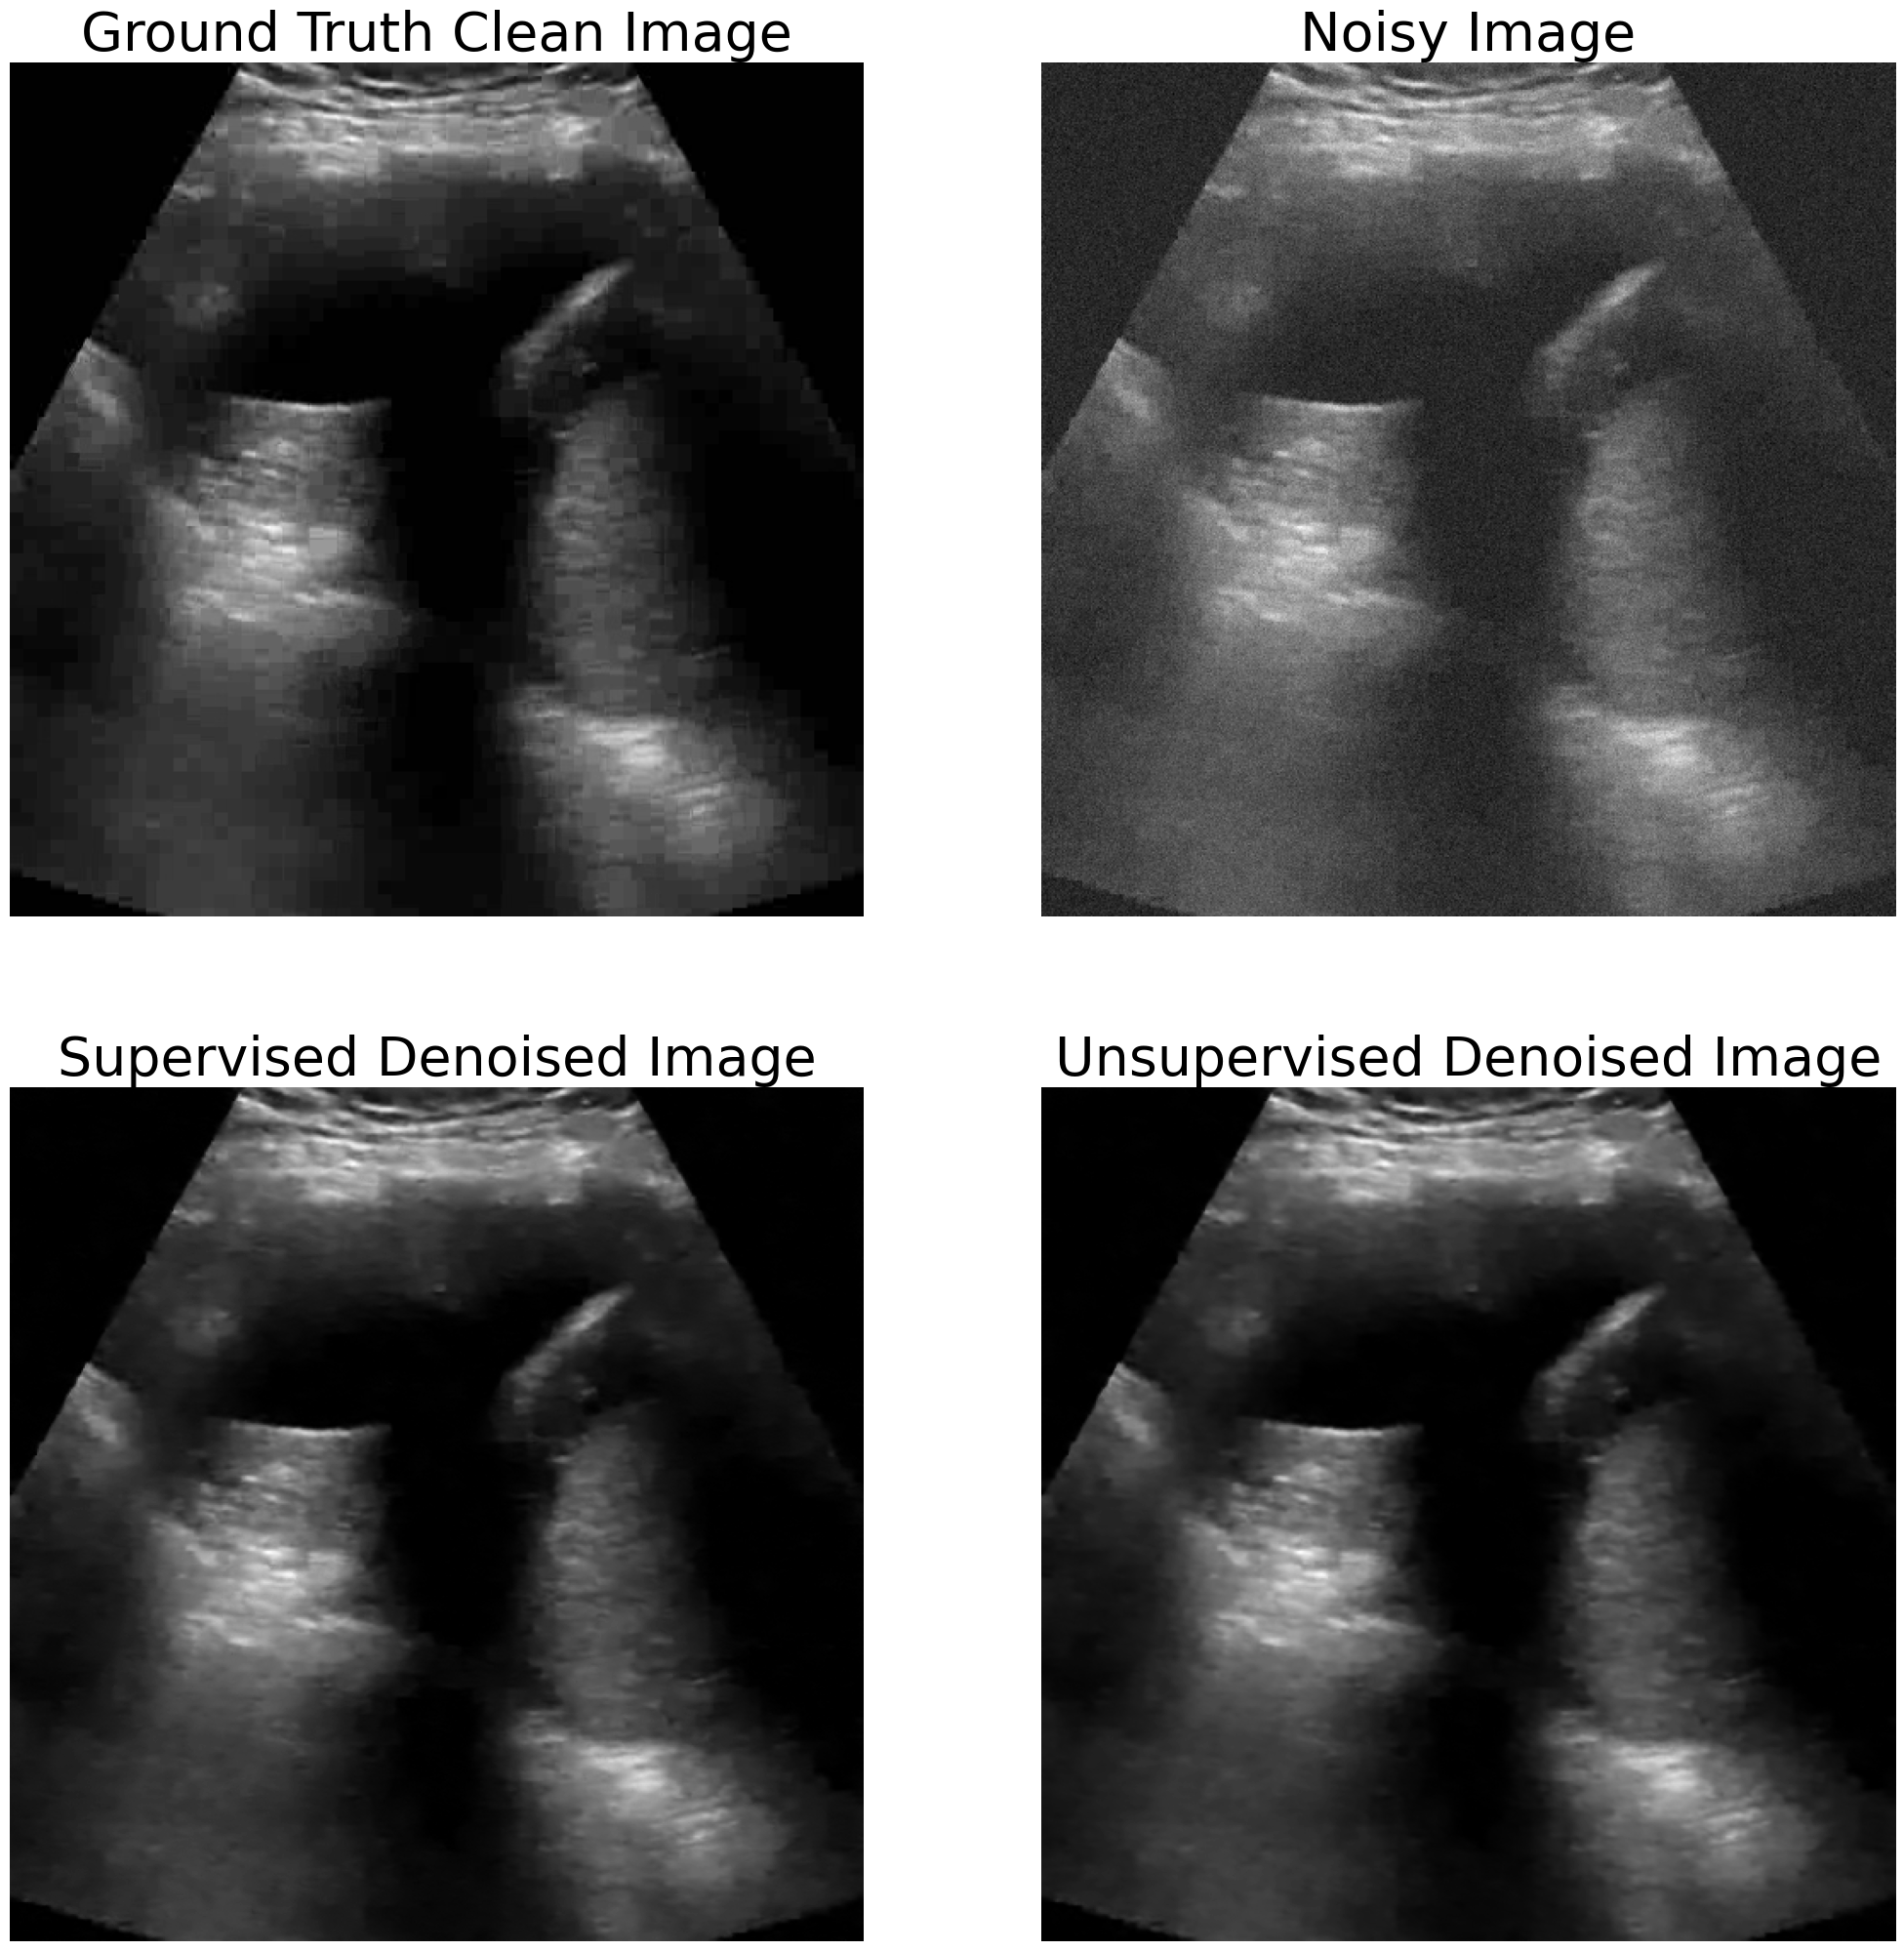

In [22]:
display(test_set_10,index=4,model_sup=model_sup_10,model_unsup=model_unsup_10,alpha=0.5,sigma=10,T=50)

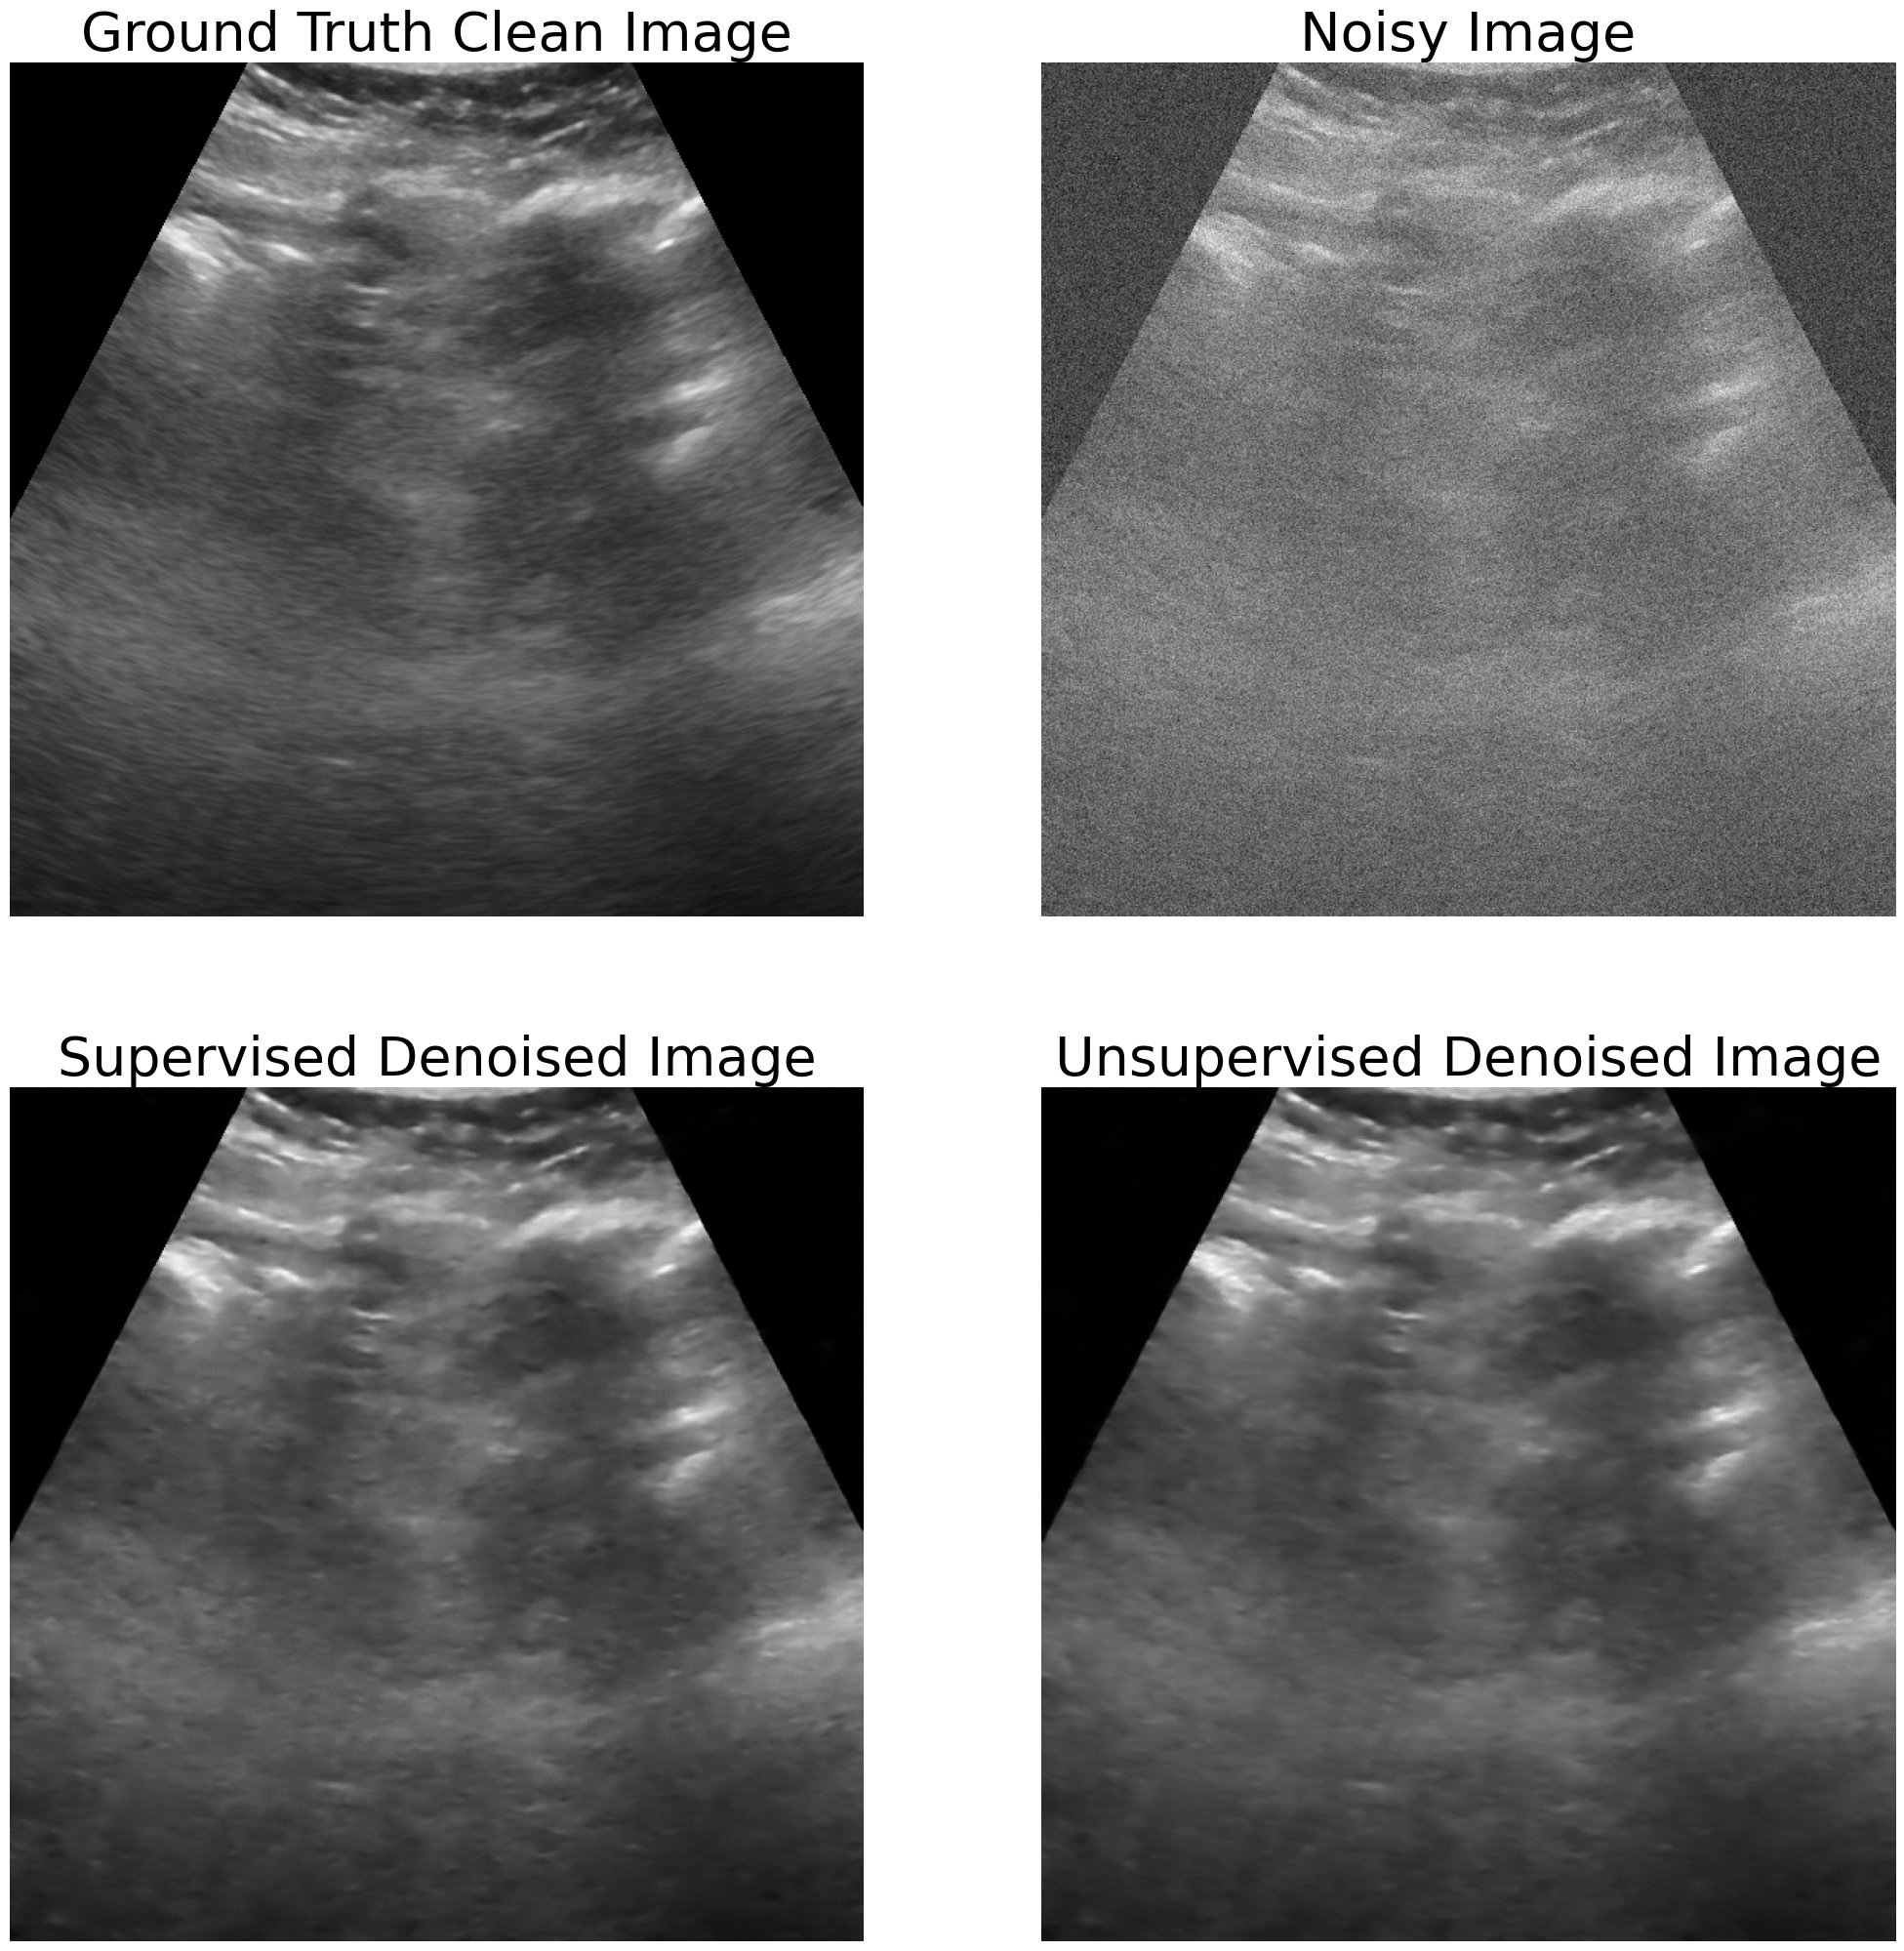

In [23]:
display(test_set_25,index=1,model_sup=model_sup_25,model_unsup=model_unsup_25,alpha=0.5,sigma=25,T=50)

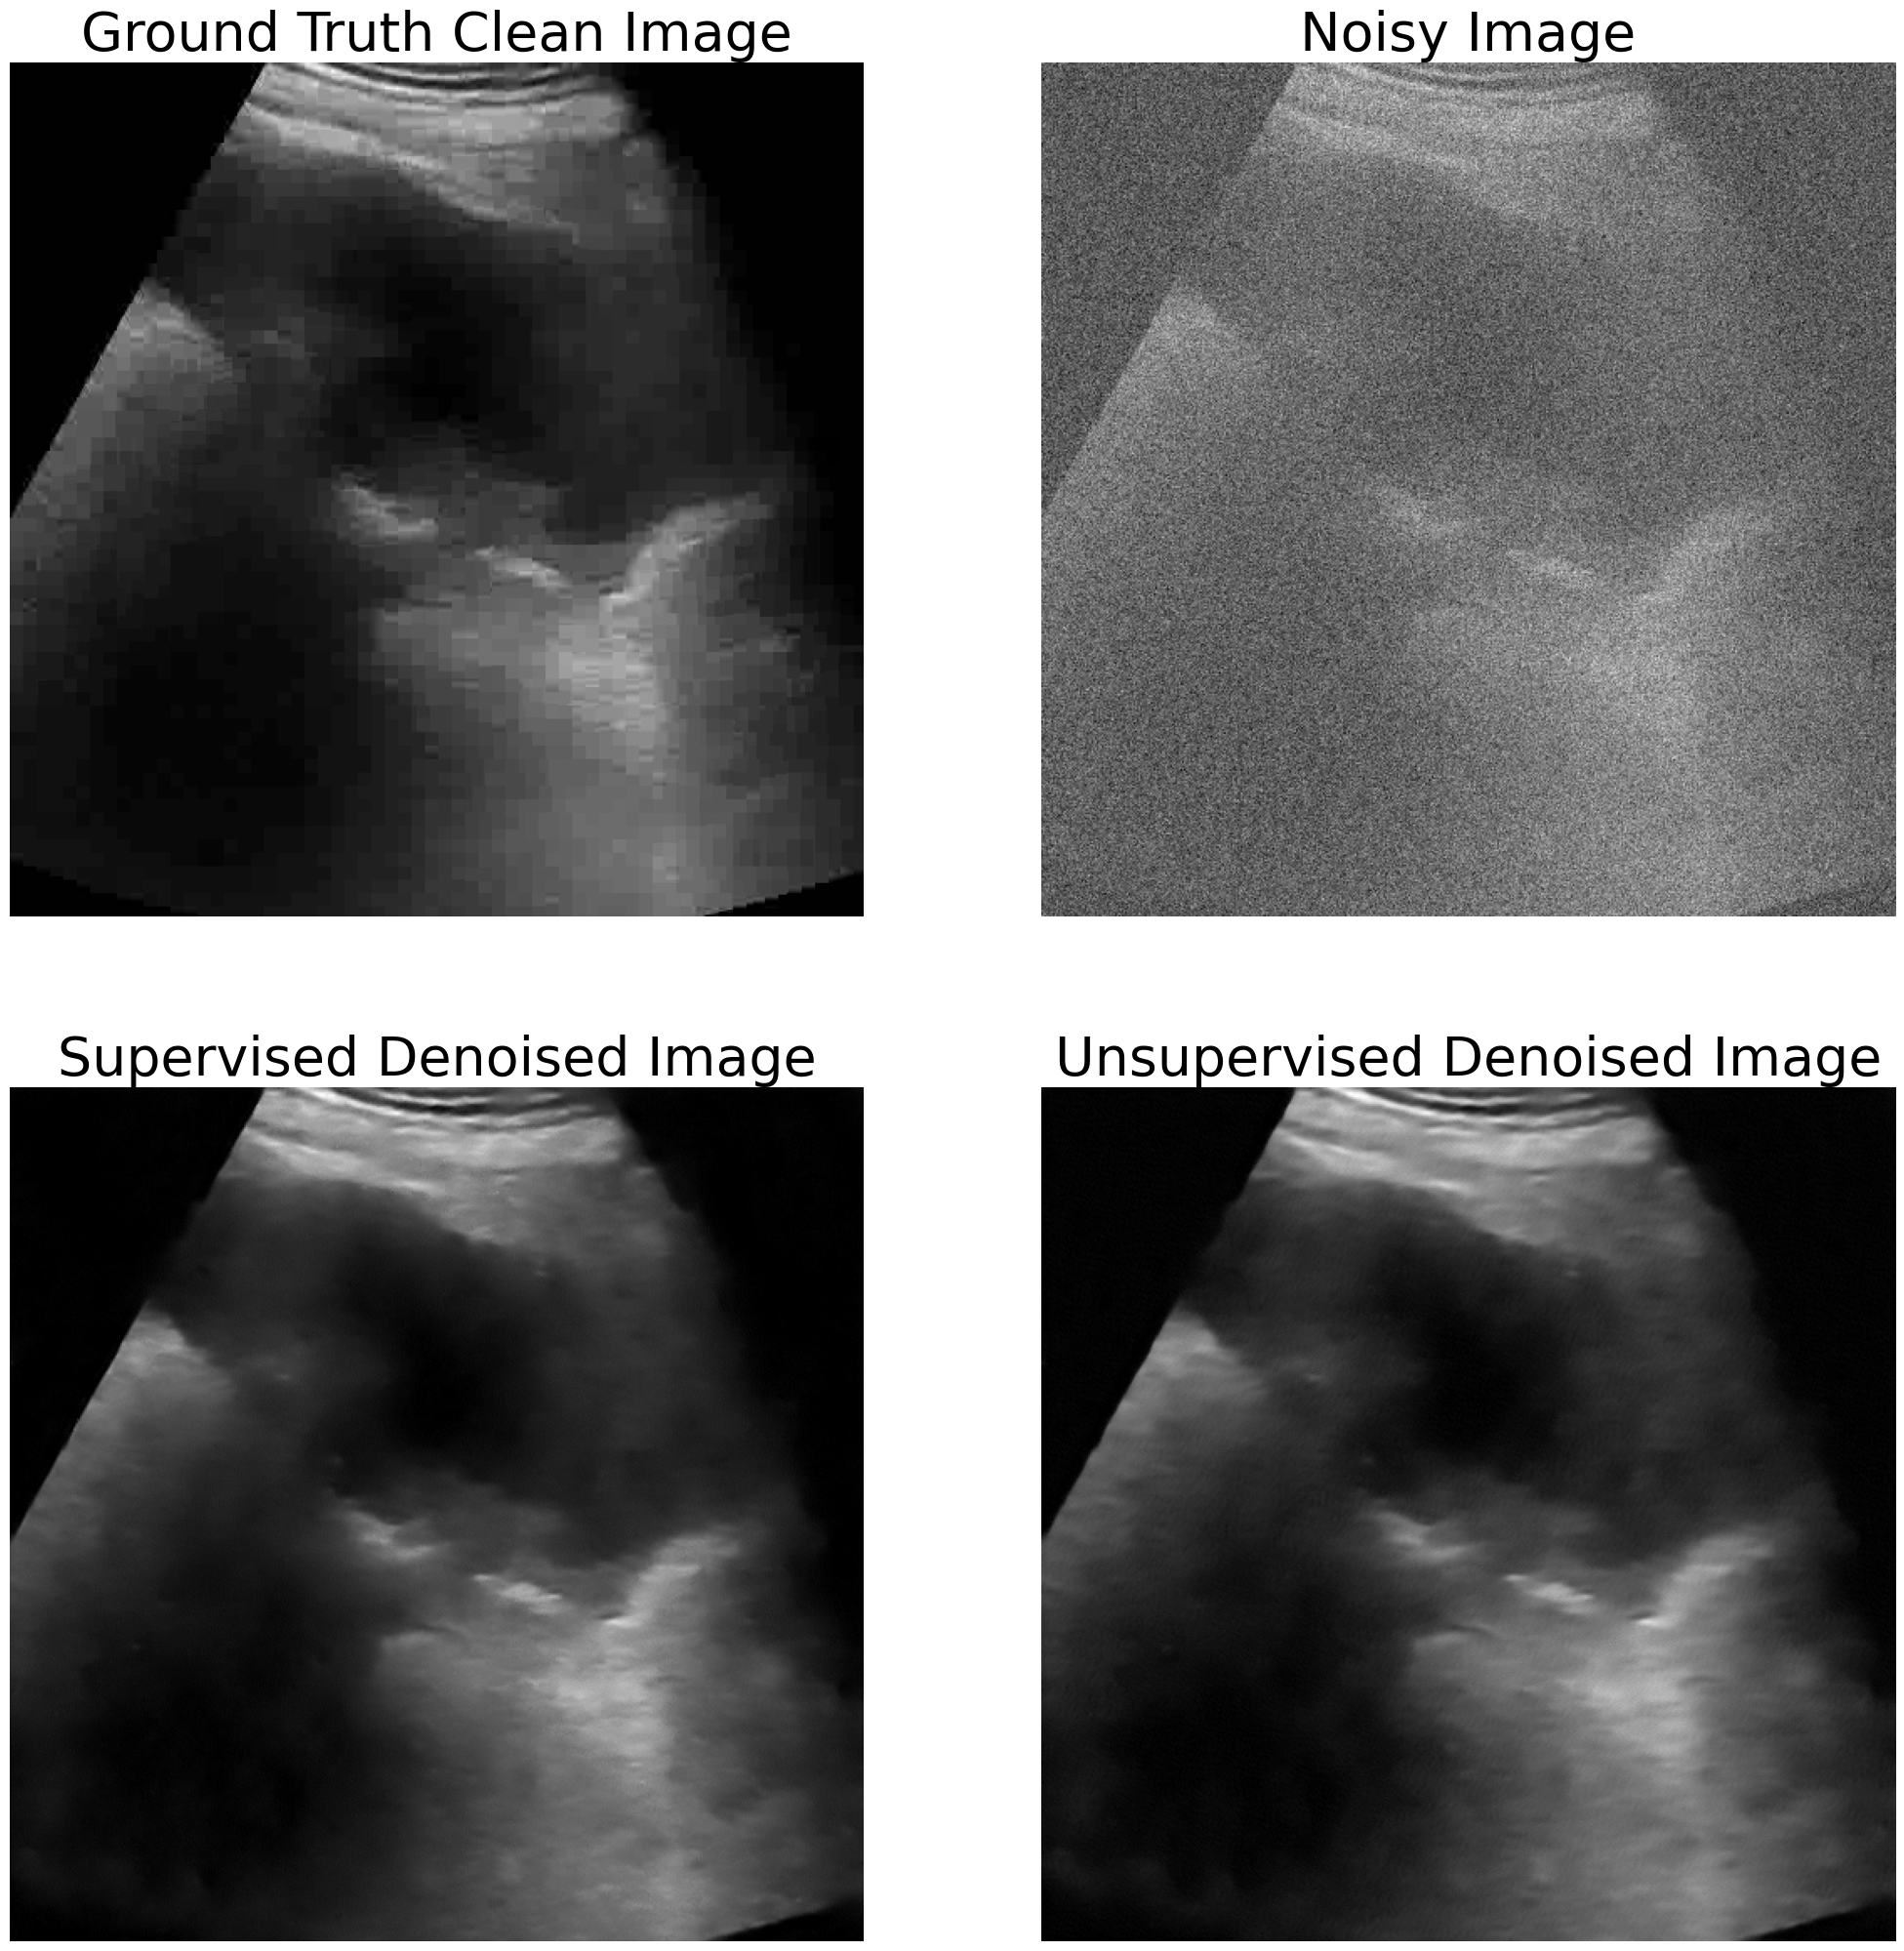

In [24]:
display(test_set_50,index=2,model_sup=model_sup_50,model_unsup=model_unsup_50,alpha=0.5,sigma=50,T=50)